# Задание msusums
## Выполнил: Хомутов Никита Юрьевич
## Студент 517 группы ВМК МГУ

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
dfX = pd.read_csv('X.csv')

In [4]:
dfX.head()

,user,day,sum
0,1,3,1146
1,1,5,71
2,1,6,65
3,1,10,63
4,1,12,31


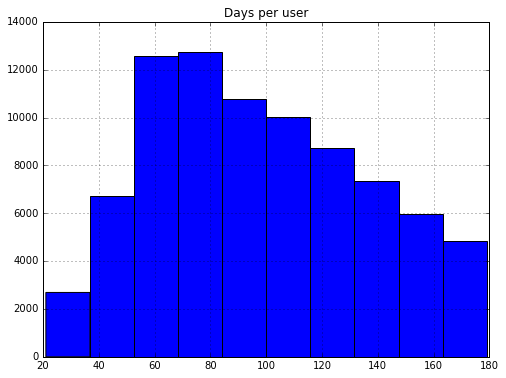

In [5]:
fig = figure(figsize=(8, 6))
hist(dfX['user'].value_counts().values)
grid()
title('Days per user')
show()

Пользователей, о которых совсем ничего не известно, нет

Добавим информацию о дне недели.
Добавим явный ключ в df, дабы потом упростить себе жизнь.

In [6]:
days_in_week = 7
dfX['weekday'] = dfX['day'] % days_in_week
dfX['week_number'] = dfX['day'] // days_in_week
dfX['key'] = dfX.index

К каждой неделе поставим в соответствие индекс. Последняя неделя, посещённая клиентом, получает индекс 1. Предпоследняя 2. И т.д.

In [7]:
dfX['week_idx'] = dfX.groupby('user').week_number.rank(method='dense',
                                                       ascending=False)

Добавим количество недель, посещённых юзером. Неэффективность по памяти компенсируется скоростью (всё же pandas -- это не SQL).

In [8]:
s_nweeks = dfX.groupby('user').week_number.nunique().to_frame()
s_nweeks.columns = ['n_weeks']
dfX = pd.merge(dfX, s_nweeks, left_on='user', right_index=True)

In [9]:
dfX.drop('week_number', axis=1, inplace=True)

Цель прогноза:

In [10]:
dfTarget = dfX.groupby('user').last()
dfTarget.head()

,day,sum,weekday,key,week_idx,n_weeks
user,,,,,,
1,445,-1,4,107,1.0,61
2,440,-1,6,229,1.0,57
3,444,-1,3,271,1.0,35
4,444,-1,3,349,1.0,54
5,441,-1,0,475,1.0,54


Из-за операции `groupby`, собственно ключ и вводился.

Исключим последний день.

In [11]:
dfX.drop(dfTarget['key'], inplace=True)

Реализуем несколько методов

In [12]:
def user_average(dfX, dfTarget=None):
    if 'weights' in dfX.columns:
        wsum = pd.concat([dfX['user'],
                          (dfX['sum'] * dfX['weights'])], axis=1).\
            groupby('user').sum()
        wnorm = dfX.groupby('user')['weights'].sum()
        wsum.columns = ['sum']
        wnorm.name = 'sum'
        return wsum.div(wnorm, axis='index')
    else:
        return dfX.groupby('user')['sum'].mean().to_frame()

In [13]:
def user_average_for_weekday(dfX, dfTarget):
    weekmask = dfX['weekday'] == dfTarget.iloc[dfX['user'] - 1]['weekday']
    df_avg_week = user_average(dfX.ix[weekmask], dfTarget)
    
    #fix misses
    df_avg_week_missed = user_average(
        dfX[~dfX.user.isin(dfX[weekmask].user.unique())],
        dfTarget)
    return pd.concat([df_avg_week, df_avg_week_missed])

In [14]:
# package wquantiles https://pypi.python.org/pypi/wquantiles/0.3
import weighted

In [15]:
def user_median(dfX, dfTarget):
    tmp = dfX.groupby('user')
    if 'weights' in dfX.columns:
        tmp = tmp.apply(lambda x: weighted.median(x['sum'], x['weights']))
        tmp.name = 'sum'
        return tmp.to_frame()
    else:
        return tmp['sum'].median().to_frame()

In [16]:
def user_median_for_weekday(dfX, dfTarget):
    weekmask = dfX['weekday'] == dfTarget.iloc[dfX['user'] - 1]['weekday']
    df_avg_week = user_median(dfX.ix[weekmask], dfTarget)
    
    # fix misses
    df_avg_week_missed = user_median(
        dfX[~dfX.user.isin(dfX[weekmask].user.unique())],
        dfTarget)
    return pd.concat([df_avg_week, df_avg_week_missed])

Сделаем схему локального контроля.

Будем оценивать качество прогноза суммы для последнего `известного` дня.
По условию задачи, оценивается MAE (значит, что нужно будет попробовать медианы вместо средних арифметических).

In [17]:
dfTarget_test = dfX.groupby('user').last()
dfX_test = dfX.drop(dfTarget_test['key'])

Оценим методы, описанные выше.

In [18]:
# anti-MemoryError version
def mae(ans_true, ans_method):
    cnt = 0
    for idx in xrange(len(ans_true)):
        cnt += abs(ans_true[idx] - ans_method[idx])
    return float(cnt) / len(ans_true)

In [19]:
def mae_df(df_ans, dfTarget_test):
    return abs(dfTarget_test['sum'] - df_ans['sum']).mean()

In [20]:
def mae_scorer(method, dfX_test=dfX_test):
    df_ans = method(dfX_test, dfTarget_test)
    return abs(df_ans['sum'] - dfTarget_test['sum']).mean()

Из данных методов лучше всего себя проявили `user_median_for_weekday` и `user_average_for_weekday`.
Очевидна сезонная (длиной в неделю) зависимость суммы пользователя.

In [54]:
df_med_week = user_median_for_weekday()
df_med_week.to_csv('ans_med_week.csv')

In [56]:
df_avg_week = user_average_for_weekday()
df_avg_week.to_csv('ans_avg_week.csv')

# Графики, изучение данных

Посмотрим на суммы средние дневные чеки.

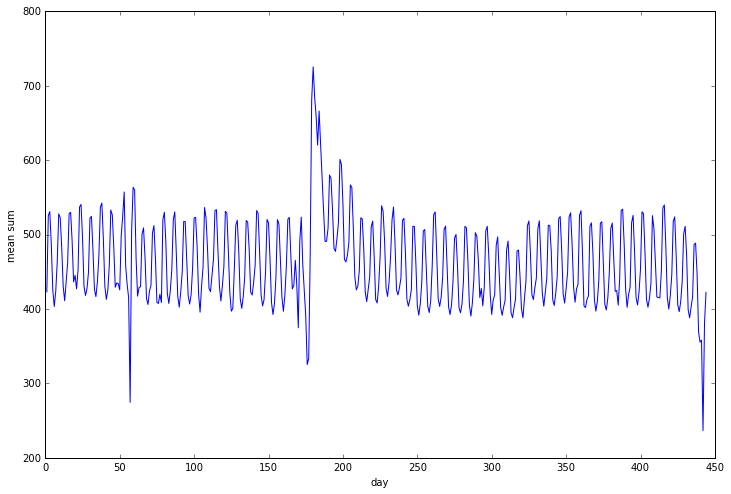

In [9]:
df_mean_daily = dfX.groupby('day')['sum'].mean().to_frame()
fig = figure(figsize=(12, 8))
plot(df_mean_daily['sum'])
xlabel('day')
ylabel('mean sum')
show()

Так же посмотрим на дневную выручку. От предыдущего графика принципиально будет отличаться отсутствием нормировки на количество человек, посетивших магазин за день.

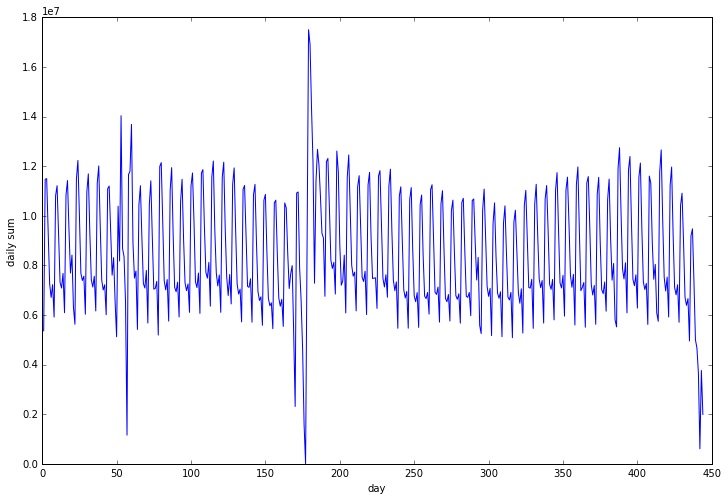

In [10]:
df_sum_daily = dfX.groupby('day')['sum'].sum().to_frame()
fig = figure(figsize=(12, 8))
plot(df_sum_daily['sum'])
xlabel('day')
ylabel('daily sum')
show()

Видна сезонность в данных, отсутствует тренд. Виден один макс-пик и два мин-пика в течение года. Из-за отсутствия конкретных дат в данных, можно только предполагать, с чем какими событиями они связаны.

Качественные различия в графиках, среднего чека и дневной выручки, явно связано с посещаемостью магазина.

На распределение количества дневных посещений 

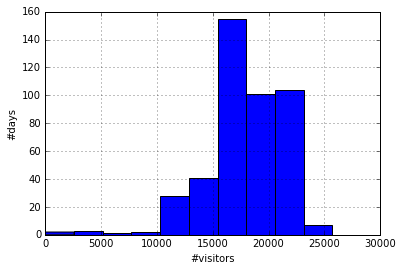

In [11]:
dfX.groupby('day').size().hist()
xlabel('#visitors')
ylabel('#days')
show()

Посмотрим на распределение посещений по дням недели, подтвердим недельную сезонность.

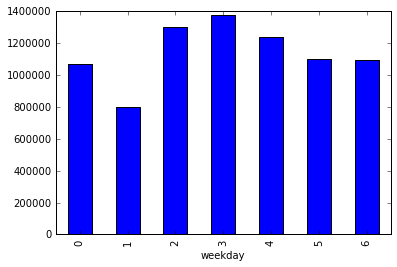

In [12]:
dfX.groupby('weekday').size().plot(kind='bar')

Различия по посещениям есть, но они не значительны. Посмотрим на распределение средних чеков по дням недели.

<Container object of 7 artists>

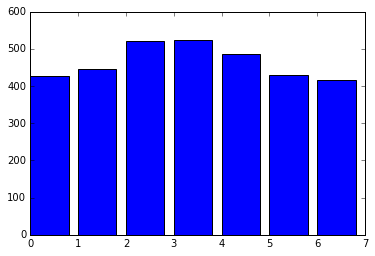

In [13]:
bar(range(7), dfX.groupby('weekday')['sum'].mean())

In [28]:
dfg = dfX.groupby('weekday').\
    apply(lambda x: x.groupby('day')['sum'].mean()).to_frame()

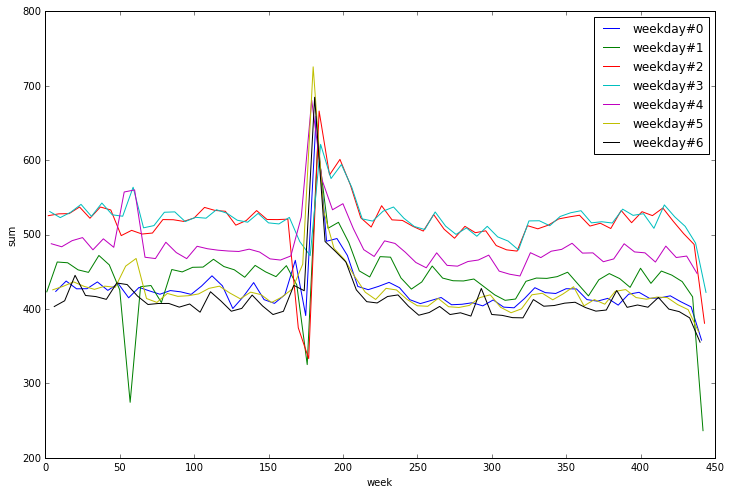

In [42]:
figure(figsize=(12, 8))
for weekday in xrange(7):
    plot(dfg.loc[weekday], label='weekday#{}'.format(weekday))
xlabel('week')
ylabel('sum')
legend()

Выделяются два дня недели: #2 и #3, которые, скорее всего, соответствуют субботе и воскресенью.

Посмотрим на распределения количества посещений и сумм покупок, совершённых однм человеком

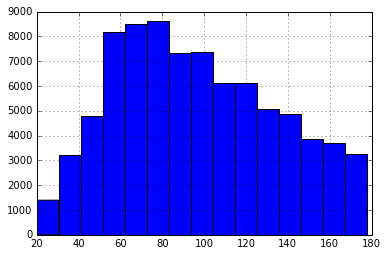

In [51]:
dfX.groupby('user').size().hist(bins=15)

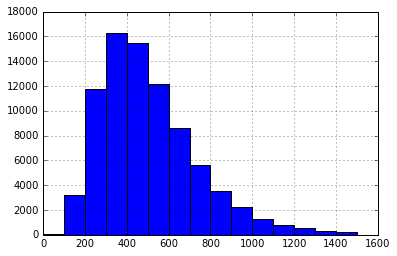

In [62]:
dfX.groupby('user')['sum'].mean().hist(bins=15, range=(0, 1500))

Распределения унимодальные, распределение среднего чека гамма-образное

## Весовые схемы

Попробуем применить весовые схемы (вес ставится в соответствие недели, и уменьшается при удалении в прошлое). Не рассматриваем недели, в которые клиент не посетил магазин.

Здесь $d$ -- количество недель, в которые клиент посетил магазин. Последней посещённой неделе соответствует индекс $i=1$, ..., первой: $i=d$.

* Линейная схема с параметром степени

    $$ w_i = \left(\frac{d-i+1}{d}\right)^\delta = \left(1 - \frac{i-1}{d}\right)^\delta, i \in \{1, \dots, d\}, \delta \in [0; +\infty) $$

* Экспоненциальные:

  $$ w_i = \delta^i, i \in \{1, \dots, d\}, \delta \in (0; 1] $$

* Обратно-степенные:

  $$ w_i  = \frac{1}{i^\delta}, i \in \{1, \dots, d\}, \delta \in [0; +\infty)  $$

Веса, естественно, следует нормировать перед использованием.

In [107]:
dfX.head()

,user,day,sum,weekday,week_number,key,week_idx,n_weeks
0,1,3,1146,3,0,0,61,61
1,1,5,71,5,0,1,61,61
2,1,6,65,6,0,2,61,61
3,1,10,63,3,1,3,60,61
4,1,12,31,5,1,4,60,61


In [21]:
def weights_linear(dfX, delta):
    return pow((1 - (dfX.week_idx - 1) / dfX.n_weeks), delta)

In [22]:
def weights_exp(dfX, delta):
    return pow(delta, dfX.week_idx)

In [23]:
def weights_reversed(dfX, delta):
    return pow(dfX.week_idx, -delta)

In [24]:
def wcombine(est_method, weight_method, delta):
    def wrapper(dfX, dfTarget):
        w = weight_method(dfX, delta)
        w.name = 'weights'
        dfXw = pd.concat([dfX, w], axis=1)
        return est_method(dfXw, dfTarget)
    wrapper.__name__ = '{} <{}: delta={}>'.format(est_method.__name__,
                                                  weight_method.__name__,
                                                  delta)
    return wrapper

In [132]:
#this will cause MemoryError
#mae_scorer(wcombine(weights_linear, user_average, 1.0))

# Эксперименты

Рассмотрим невесовые схемы

In [25]:
import sys
sys.path.append(r'D:\home')

In [26]:
# git: https://github.com/urandon/pyloggers.git
from pyloggers.telegram_logger import TelegramLogger
tl = TelegramLogger(name='msusums', print_dual_logging=False)

In [200]:
estimate_methods = [
    user_average,
    user_average_for_weekday,
    user_median,
    user_median_for_weekday
]

scores = {method.__name__: {'MAE penult': mae_scorer(method)}
          for method in estimate_methods}
pd.DataFrame(scores).T

,MAE penult
user_average,269.916970
user_average_for_weekday,256.218031
user_median,264.383650
user_median_for_weekday,253.784068


Методы, учитывающие только день недели покупки оказались лучше по качеству.

Попробуем весовые схемы. Воспользуемся методом `user_average_for_weekday` для оценки и настройки параметров весовых схем. Несмотря на лучшую теоретическую обоснованность выбора медианы для минимизации MAE, чем среднего арифметического, результат на Kaggle был лучше у среднего, а не у `user_median_for_weekday`.

In [201]:
scores = {}
for delta in linspace(0.1, 1, 10):
    weight_methods = [
        weights_linear,
        weights_exp,
        weights_reversed,
    ]
    
    scores[delta] = {}
    for method in weight_methods:
        w = method(dfX_test, delta)
        w.name = 'weights'
        dfXw_test = pd.concat([dfX_test, w], axis=1)
        df_ans = user_average_for_weekday(dfXw_test, dfTarget_test)
        if df_ans.isnull().any().any():
            score = np.nan
        else:
            score = mae_df(dfTarget_test, df_ans)
        scores[delta][method.__name__] = score
        tl.push('{} delta {} done: score {}'.format(
                method.__name__, delta, score))

In [229]:
pd.DataFrame(scores).T

,weights_exp,weights_linear,weights_reversed
0.1,313.611866,255.875218,255.709931
0.2,309.298288,255.647365,255.288044
0.3,305.072077,255.517366,254.974355
0.4,300.575944,255.456888,254.788023
0.5,295.505394,255.452483,254.747616
0.6,289.493904,255.968735,254.869772
0.7,282.052749,255.566776,255.155918
0.8,272.548939,255.672015,255.617808
0.9,260.661156,256.282418,256.255500
1.0,256.218031,256.447291,257.054779


*  Экспоненциальная схема не дала никакого улучшения. Далее её не рассматриваем
*  Линейная схема  показала лучший результат при `delta` = 0.5
*  Обратно-степенная схема показала свой лучший результат при `delta` = 0.5

### Выпуклые комбинации

Попробуем выпуклые комбинации лучших решений.

In [221]:
best_params = [
    (weights_linear, 0.5),
    (weights_reversed, 0.5)
]

best_anss = []

for method, delta in best_params:
    w = method(dfX_test, delta)
    w.name = 'weights'
    dfXw_test = pd.concat([dfX_test, w], axis=1)
    df_ans = user_average_for_weekday(dfXw_test, dfTarget_test)
    best_anss += [df_ans]
    tl.push('{} delta {}'.format(method.__name__, delta))
tl.push('------------------------')

In [ ]:
best_params

In [298]:
scores_alpha = {}
for alpha in linspace(0, 1, 10):
    df_alpha = best_anss[0] * alpha + best_anss[1] * (1-alpha)
    scores_alpha[alpha] = mae_df(df_alpha, dfTarget_test)

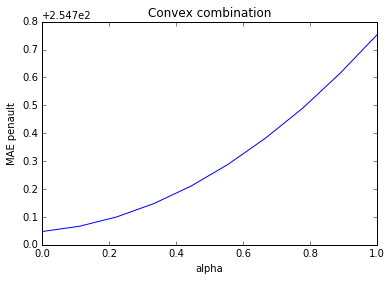

In [299]:
plot(*zip(*sorted(scores_alpha.items())))
xlabel('alpha')
ylabel('MAE penault')
title('Convex combination')
show()

Перебор выпуклых комбинаций исключил `(weights_linear, 0.5)`. Лучшая весовая модель: `(weights_linear, 0.5)`

In [326]:
df_best_aw = best_anss[1]

In [328]:
mae_df(df_best_aw, dfTarget_test)

254.74761572563699

Так же добавим в выпуклые комбинации результаты `user_average`. Посмотрим, улучшится ли результат

In [306]:
scores = {}
for delta in linspace(0.1, 1, 10):
    weight_methods = [
        weights_linear,
        weights_exp,
        weights_reversed,
    ]
    
    scores[delta] = {}
    for method in weight_methods:
        w = method(dfX_test, delta)
        w.name = 'weights'
        dfXw_test = pd.concat([dfX_test, w], axis=1)
        df_ans = user_average(dfXw_test, dfTarget_test)
        if df_ans.isnull().any().any():
            score = np.nan
        else:
            score = mae_df(dfTarget_test, df_ans)
        scores[delta][method.__name__] = score
        tl.push('{} delta {} done: score {}'.format(
                method.__name__, delta, score))
tl.push('------------------------')

In [325]:
pd.DataFrame(scores).T

,weights_exp,weights_linear,weights_reversed
0.1,331.814442,269.606311,269.579328
0.2,318.457798,269.356904,269.268471
0.3,307.733922,269.114759,268.994777
0.4,298.698228,268.919138,268.767225
0.5,501.529783,268.749847,268.605140
0.6,284.111818,268.602717,268.523655
0.7,278.081657,268.474741,268.534841
0.8,272.708436,268.364231,268.654869
0.9,268.480810,268.269407,268.896930
1.0,501.529783,268.189182,269.267593


Результаты для этого метода везде плохи. В качестве лучшего возьмём `(weights_linear, 1.0)`

In [330]:
best_params = [
    (user_average_for_weekday, weights_reversed, 0.5),
    (user_average, weights_linear, 0.5)
]

best_anss = []

for est, method, delta in best_params:
    w = method(dfX_test, delta)
    w.name = 'weights'
    dfXw_test = pd.concat([dfX_test, w], axis=1)
    df_ans = est(dfXw_test, dfTarget_test)
    best_anss += [df_ans]
    tl.push('{} delta {}'.format(method.__name__, delta))
tl.push('------------------------')

In [403]:
scores_alpha = {}
for alpha in linspace(0, 1, 11):
    df_alpha = best_anss[0] * alpha + best_anss[1] * (1-alpha)
    scores_alpha[alpha] = mae_df(df_alpha, dfTarget_test)

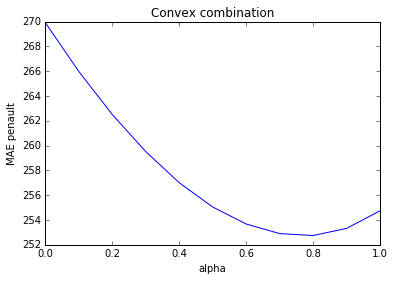

In [404]:
plot(*zip(*sorted(scores_alpha.items())))
xlabel('alpha')
ylabel('MAE penault')
title('Convex combination')
show()

Добавление `user_average_week` в линейную комбинацию всё-таки улучшило её.

Лучший результат: $(uafw, wr delta=0.5) * 0.8 + (ua, wl delta=0.5) * 0.2$

In [418]:
alpha = 0.8
best_total = best_anss[0] * alpha + best_anss[1] * (1-alpha)
print 'MAE penault:', mae_df(best_total, dfTarget_test)

MAE penault: 252.560219846


# Итоговый алгоритм

In [28]:
best_params = [
    (user_average_for_weekday, weights_reversed, 0.5),
    (user_average, weights_linear, 0.5)
]
alphas = [0.8, 0.2]

best_anss = []
for est, method, delta in best_params:
    w = method(dfX, delta)
    w.name = 'weights'
    dfXw = pd.concat([dfX, w], axis=1)
    df_ans = est(dfXw, dfTarget)
    best_anss += [df_ans]
    tl.push('{} delta {}'.format(method.__name__, delta))
best_ans = best_anss[0] * alphas[0] + best_anss[1] * alphas[1]
tl.push('------------------------')

In [419]:
print 'MAE penault:', mae_df(best_ans, dfTarget_test)

MAE penault: 252.560219846


In [29]:
best_ans.to_csv('best_ans-bugfix.csv')